# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.656885,False,-0.299071
1,1.889930,True,8.495853
2,-1.165882,False,-1.447712
3,0.582056,False,1.701473
4,-2.581135,False,-3.331185
...,...,...,...
995,0.497085,True,6.504748
996,-0.342295,True,3.953657
997,-0.653641,False,-1.576820
998,-0.406649,True,3.890597


<Axes: xlabel='v0'>

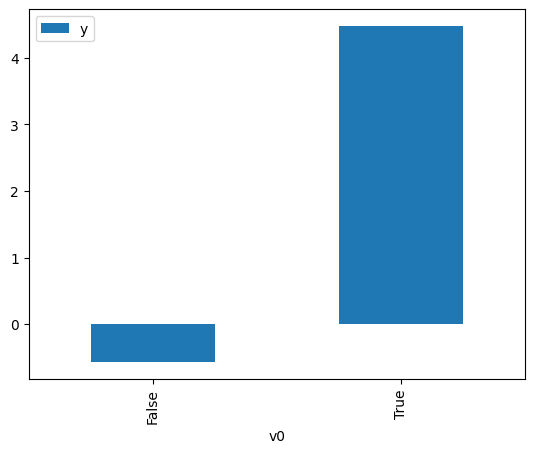

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

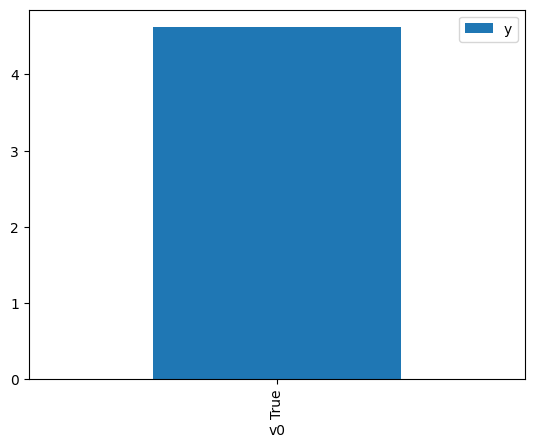

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.419280,False,-2.698724,0.604875,1.653235
1,-1.335955,False,-1.847423,0.798562,1.252251
2,0.570623,False,1.712644,0.353954,2.825224
3,0.661332,False,0.781223,0.332731,3.005433
4,-0.487866,False,-0.187255,0.621757,1.608346
...,...,...,...,...,...
995,0.979580,False,2.223974,0.263821,3.790445
996,1.491719,False,3.311740,0.173962,5.748379
997,-0.489798,False,-1.111616,0.622228,1.607128
998,-0.858891,False,-1.563904,0.707265,1.413898


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.910890,True,4.348244,0.281687,3.550044
1,0.526948,True,7.704552,0.635612,1.573287
2,-0.742876,True,3.595488,0.318275,3.141938
3,1.349560,True,5.743681,0.803804,1.244084
4,0.657380,True,6.526140,0.666358,1.500695
...,...,...,...,...,...
995,0.538204,True,4.782649,0.638314,1.566628
996,0.044565,True,5.111167,0.513910,1.945867
997,0.115424,True,6.932372,0.532257,1.878793
998,-0.406649,True,3.890597,0.398263,2.510903


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.949
Model:                            OLS   Adj. R-squared (uncentered):              0.949
Method:                 Least Squares   F-statistic:                              9216.
Date:                Mon, 19 May 2025   Prob (F-statistic):                        0.00
Time:                        22:53:37   Log-Likelihood:                         -1393.2
No. Observations:                1000   AIC:                                      2790.
Df Residuals:                     998   BIC:                                      2800.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8431      0.030     61.262      0.000       1.784       1.902
x2             5.0012      0.046    108.005      0.000       4.910       5.092
==============================================================================
Omnibus:                        2.324   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.208
Skew:                           0.082   Prob(JB):                        0.331
Kurtosis:                       3.162   Cond. No.                         1.60
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""